In [1]:
print('hello')

hello


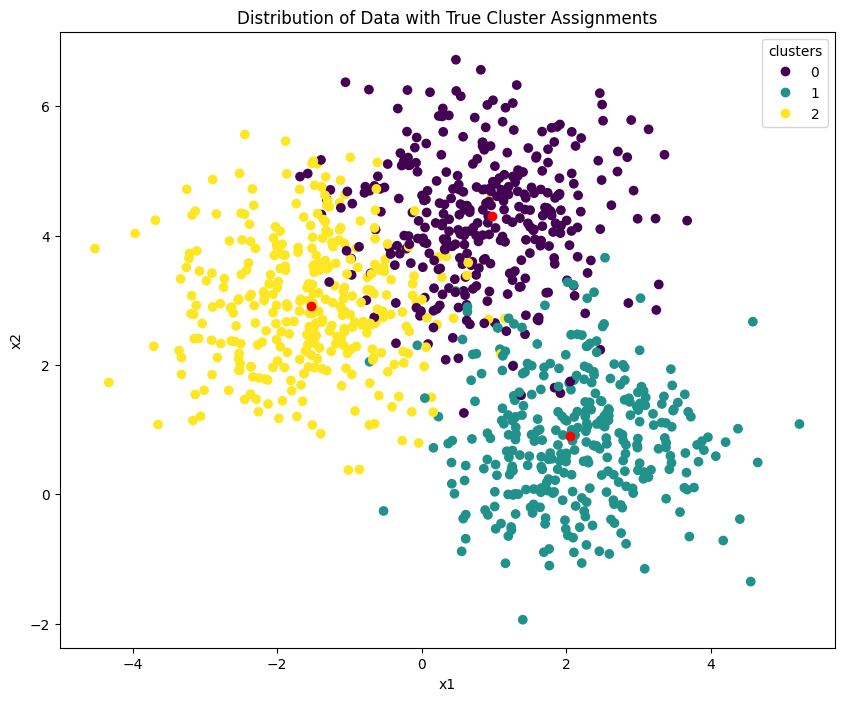

In [2]:
# imports
import numpy as np
from typing import Tuple, Dict
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

# Membuat Algoritma kMeans
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """
    def __init__(self, K: int=3, n_init: int=20, max_iters: int=100) -> None:
        """
        Initialiser function for a class instance
        Inputs:
        K -> integer number of clusters to assign
        n_init -> integer number of times the algorithm will be applied when training
        max_iters -> maximum number of iterations the algorithm is allowed
        to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        
        self.K = K
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters
        
    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.K
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters
        
    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output: numpy array indicating cluster assignment per sample with shape:[number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:,np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output: list of numpy arrays of centroid for cluster, each array with shape: [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])
    
    def __compute_wcss(self, X : np.array, cluster_assignment : np.array, centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
        tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster 
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:], X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)
        
    def __update_centroids(self, X : np.array, cluster_assignment : np.array) -> np.array:
        """
        Private function to update cluster centroids
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape:[number_samples,]
        Output: numpy array of centroids with shape: [K, number_features]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute new centroids & return
        return np.array([np.mean(x, axis=0) for x in X_clusters])

    def fit(self, X : np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS
        Inputs:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        """
        # initialise wcss score
        self.total_wcss = np.inf
        # loop over all iterations requested
        for _ in range(self.n_init):
        # initialise centroids
            centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.K))
            iteration = 0
            while (not np.array_equal(centroid_diff,np.zeros(self.K))) and iteration < self.max_iters:
                # assign samples to clusters
                cluster_assignment = self.__assign_samples(X, centroids)
                # update centroids
                centroids = self.__update_centroids(X, cluster_assignment)
                # compute difference between centroids
                centroid_diff = np.abs(old_centroids - centroids)
                # increment counter & reset old_centroids
                iteration += 1
                old_centroids = np.copy(centroids)
            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids = centroids
                
    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids
        Input:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output: numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)
        
    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)
        Output: tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)
        
    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)
        Output: numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids
        
    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
        deep -> boolean input parameter
        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K, 
                'n_init':self.n_init, 
                'max_iters':self.max_iters}
        
# Memproduksi dataset
X, y, centers = make_blobs(n_samples=1000, centers=3, n_features=2, return_centers=True, random_state=0)
# visualise data
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y)
sc_centers = ax.scatter(centers[:,0],centers[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [3]:
type(X)

numpy.ndarray

In [4]:
print(X)

[[-0.80723584  2.66946295]
 [ 1.9263585   4.15243012]
 [-1.50016563  3.10133251]
 ...
 [ 0.41230223  0.49159186]
 [-2.53294087  2.09633244]
 [ 1.10777893  1.14210712]]


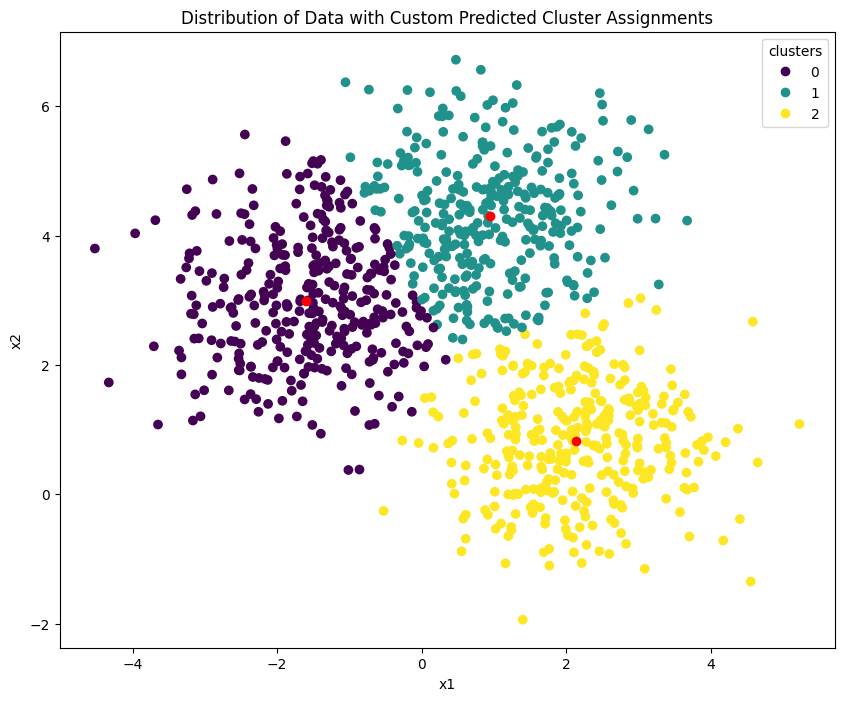

In [5]:
# Buat model KMeans
clt = KMeans(max_iters=300)
# Cocokkan model dengan data
clt.fit(X)
# Dapatkan prediksi
y_pred = clt.predict(X)
# Dapatkan prediksi sentroid
centers_pred = clt.return_centroids()
# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Custom Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [6]:
# Mendapatkan nilai cluster errors
clt.return_wcss()
# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[2,0,1]])}')
# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 2
y_pred[idx_1] = 0
y_pred[idx_2] = 1
# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')


The mean absolute error between the predicted and true centroids is: 2.3745686641240695
Accuracy score: 0.9180
Precision score: 0.9179
Recall score: 0.9180
F1 score: 0.9179


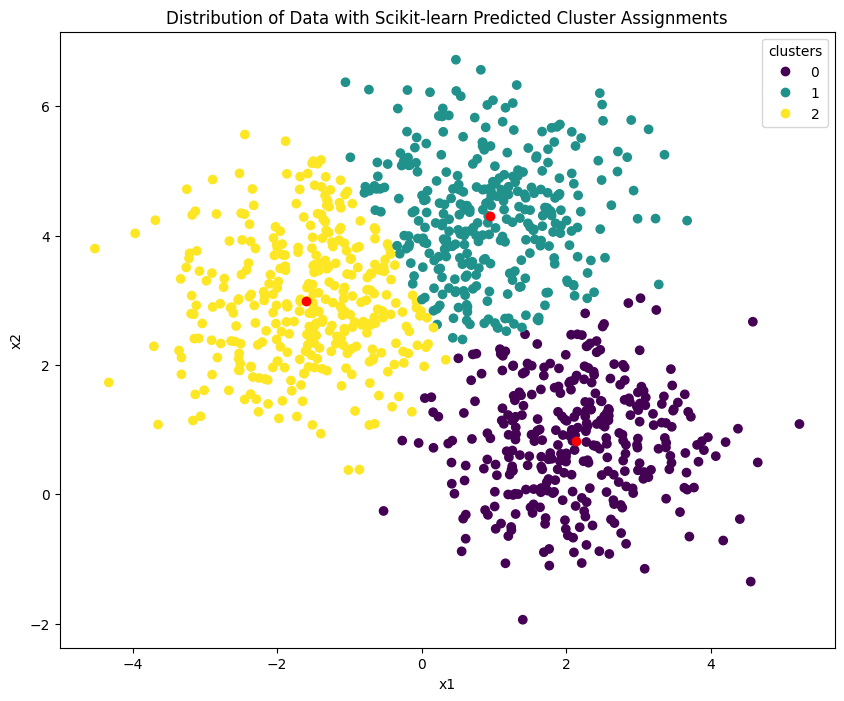

In [7]:
# import scikit-learn K-Means
from sklearn.cluster import KMeans
# Buat model KMeans
clt = KMeans(n_clusters=3, max_iter=300, random_state=0)
# Cocokkan model dengan data
clt.fit(X)
# Dapatkan prediksi
y_pred = clt.predict(X)
# Dapatkan prediksi sentroid
centers_pred = clt.cluster_centers_
# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Scikit-learn Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [8]:
# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[1,0,2]])}')
# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 1
y_pred[idx_1] = 0
y_pred[idx_2] = 2
# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

The mean absolute error between the predicted and true centroids is: 0.05720900868245904
Accuracy score: 0.9180
Precision score: 0.9179
Recall score: 0.9180
F1 score: 0.9179


In [9]:
import pandas as pd
df = pd.read_csv('C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm9/air+quality/AirQualityUCI.csv')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888"


In [10]:
for col in df.columns:
    print(f'{col} mempunyai value unik: {df[col].unique()}')
    print(f'{col} mempunyai total bilangan NaN: {df[col].isnull().sum()}')
    print('\n')

Date mempunyai value unik: ['10/03/2004' '11/03/2004' '12/03/2004' '13/03/2004' '14/03/2004'
 '15/03/2004' '16/03/2004' '17/03/2004' '18/03/2004' '19/03/2004'
 '20/03/2004' '21/03/2004' '22/03/2004' '23/03/2004' '24/03/2004'
 '25/03/2004' '26/03/2004' '27/03/2004' '28/03/2004' '29/03/2004'
 '30/03/2004' '31/03/2004' '01/04/2004' '02/04/2004' '03/04/2004'
 '04/04/2004' '05/04/2004' '06/04/2004' '07/04/2004' '08/04/2004'
 '09/04/2004' '10/04/2004' '11/04/2004' '12/04/2004' '13/04/2004'
 '14/04/2004' '15/04/2004' '16/04/2004' '17/04/2004' '18/04/2004'
 '19/04/2004' '20/04/2004' '21/04/2004' '22/04/2004' '23/04/2004'
 '24/04/2004' '25/04/2004' '26/04/2004' '27/04/2004' '28/04/2004'
 '29/04/2004' '30/04/2004' '01/05/2004' '02/05/2004' '03/05/2004'
 '04/05/2004' '05/05/2004' '06/05/2004' '07/05/2004' '08/05/2004'
 '09/05/2004' '10/05/2004' '11/05/2004' '12/05/2004' '13/05/2004'
 '14/05/2004' '15/05/2004' '16/05/2004' '17/05/2004' '18/05/2004'
 '19/05/2004' '20/05/2004' '21/05/2004' '22/05/20

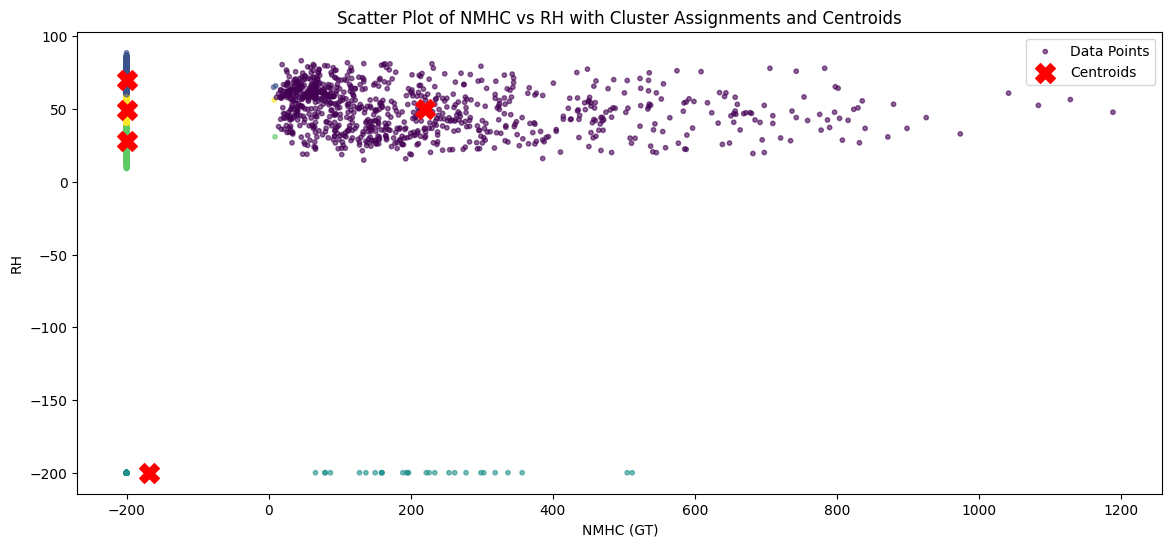


Evaluation Metrics:
Mean Absolute Error (MAE): 0.8959
Accuracy: 0.4413
Precision Score: 0.9997
Recall Score: 0.4413
F1 Score: 0.5971


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from scipy.optimize import linear_sum_assignment

class KMeansClustering:
    def __init__(self, n_clusters=5, n_init=20, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.scaler = StandardScaler()
        
    def initialize_centroids(self, X):
        """Initialize centroids randomly from data points"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        centroid_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[centroid_indices]
    
    def assign_clusters(self, X, centroids):
        """Assign each point to nearest centroid"""
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)
    
    def update_centroids(self, X, labels):
        """Update centroids based on mean of assigned points"""
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])
        return new_centroids
    
    def compute_inertia(self, X, labels, centroids):
        """Compute sum of squared distances of samples to their closest centroid"""
        distances = np.sqrt(((X - centroids[labels])**2).sum(axis=1))
        return np.sum(distances**2)
    
    def fit_single(self, X):
        """Perform single run of K-means"""
        # Initialize centroids
        centroids = self.initialize_centroids(X)
        prev_labels = None
        
        for _ in range(self.max_iter):
            # Assign points to clusters
            labels = self.assign_clusters(X, centroids)
            
            # Check for convergence
            if prev_labels is not None and np.all(labels == prev_labels):
                break
                
            # Update centroids
            centroids = self.update_centroids(X, labels)
            prev_labels = labels
            
        inertia = self.compute_inertia(X, labels, centroids)
        return labels, centroids, inertia
    
    def fit(self, X_scaled):
        """Perform multiple runs of K-means and select best result"""
        best_inertia = float('inf')
        best_labels = None
        best_centroids = None
        
        # Perform multiple initializations
        for _ in range(self.n_init):
            labels, centroids, inertia = self.fit_single(X_scaled)
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels
                best_centroids = centroids
        
        self.cluster_labels = best_labels
        self.centroids = best_centroids
        return self.cluster_labels, self.centroids
    
    def load_and_prepare_data(self, file_path):
        df = pd.read_csv(file_path)
        df = df.drop(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)',
                      'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
                      'PT08.S5(O3)', 'T', 'AH'], axis=1)
        
        NMHC_array = df['NMHC(GT)'].to_numpy().reshape(-1, 1)
        df['RH'] = df['RH'].replace(',', '.', regex=True).astype(float)
        RH_array = df['RH'].to_numpy().reshape(-1, 1)
        
        X = np.hstack((NMHC_array, RH_array))
        X_scaled = self.scaler.fit_transform(X)
        
        return X, X_scaled
    
    def plot_clusters(self, X):
        plt.figure(figsize=(14, 6))
        plt.scatter(X[:, 0], X[:, 1], c=self.cluster_labels, cmap='viridis', alpha=0.6, s=10, label='Data Points')
        centroids_unscaled = self.scaler.inverse_transform(self.centroids)
        plt.scatter(centroids_unscaled[:, 0], centroids_unscaled[:, 1], c='red', marker='X', s=200, label='Centroids')
        plt.title('Scatter Plot of NMHC vs RH with Cluster Assignments and Centroids')
        plt.xlabel('NMHC (GT)')
        plt.ylabel('RH')
        plt.legend(loc='upper right')
        plt.show()
    
    def assign_quantiles(self, data, quantiles):
        labels = np.zeros(data.shape[0], dtype=int)
        labels[data > quantiles[3]] = 4
        labels[(data > quantiles[2]) & (data <= quantiles[3])] = 3
        labels[(data > quantiles[1]) & (data <= quantiles[2])] = 2
        labels[(data > quantiles[0]) & (data <= quantiles[1])] = 1
        labels[data <= quantiles[0]] = 0
        return labels
    
    def map_clusters_to_labels(self, y_true):
        contingency_matrix = np.zeros((5, 5), dtype=int)
        for true_label in range(5):
            for cluster_label in range(5):
                contingency_matrix[true_label, cluster_label] = np.sum((y_true == true_label) & (self.cluster_labels == cluster_label))
        row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
        mapping = {cluster_label: true_label for true_label, cluster_label in zip(row_ind, col_ind)}
        mapped_labels = np.vectorize(mapping.get)(self.cluster_labels)
        return mapped_labels
    
    def evaluate(self, y_true, y_mapped):
        mae = mean_absolute_error(y_true, y_mapped)
        accuracy = accuracy_score(y_true, y_mapped)
        precision = precision_score(y_true, y_mapped, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_mapped, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_mapped, average='weighted', zero_division=0)
        return mae, accuracy, precision, recall, f1

# =========================
# Main Script
# =========================

file_path = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm9/air+quality/AirQualityUCI.csv'
kmeans_clustering = KMeansClustering()

# Load and prepare data
X, X_scaled = kmeans_clustering.load_and_prepare_data(file_path)

# Fit the model
cluster_labels, centroids = kmeans_clustering.fit(X_scaled)

# Plot clusters
kmeans_clustering.plot_clusters(X)

# Evaluation Metrics
quantiles = np.percentile(X[:, 0], [20, 40, 60, 80])
y_true = kmeans_clustering.assign_quantiles(X[:, 0], quantiles)
y_mapped = kmeans_clustering.map_clusters_to_labels(y_true)

mae, accuracy, precision, recall, f1 = kmeans_clustering.evaluate(y_true, y_mapped)

print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


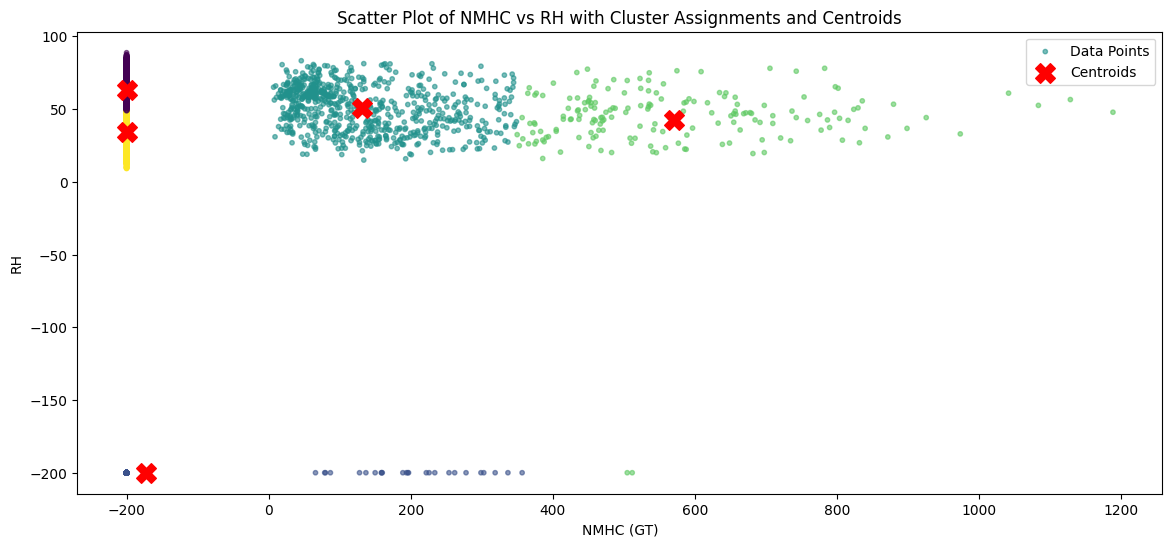


Evaluation Metrics for NMHC_array:
Mean Absolute Error (MAE): 0.9054
Precision Score: 1.0000
Recall Score: 0.5210
F1 Score: 0.6815


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from scipy.optimize import linear_sum_assignment

# =========================
# Load and Prepare Data
# =========================

# Load dataset
file_path = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm9/air+quality/AirQualityUCI.csv'
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)',
              'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
              'PT08.S5(O3)', 'T', 'AH'], axis=1)

# Convert NMHC(GT) to NumPy array and ensure it is 2D
NMHC_array = df['NMHC(GT)'].to_numpy().reshape(-1, 1)  # Shape (n_samples, 1)

# Convert RH to NumPy array and ensure it is 2D, replacing commas with periods
df['RH'] = df['RH'].replace(',', '.', regex=True).astype(float)
RH_array = df['RH'].to_numpy().reshape(-1, 1)  # Shape (n_samples, 1)

# Combine NMHC and RH into a single feature matrix
X = np.hstack((NMHC_array, RH_array))

# Standardize the features for better clustering performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# K-Means Clustering using Sklearn
# =========================

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=42)
kmeans.fit(X_scaled)

# Predict cluster assignments
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# =========================
# Scatter Plot with Centroids for NMHC vs RH
# =========================

plt.figure(figsize=(14, 6))

# Scatter plot of NMHC vs RH colored by cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=10, label='Data Points')

# Plot centroids (unscaled back to original feature space)
centroids_unscaled = scaler.inverse_transform(centroids)
plt.scatter(centroids_unscaled[:, 0], centroids_unscaled[:, 1], c='red', marker='X', s=200, label='Centroids')

# Add labels and title
plt.title('Scatter Plot of NMHC vs RH with Cluster Assignments and Centroids')
plt.xlabel('NMHC (GT)')
plt.ylabel('RH')
plt.legend(loc='upper right')

# Display the plot
plt.show()


# =========================
# Evaluation Metrics for NMHC_array
# =========================

# Define quintiles (20%, 40%, 60%, 80%) to split the data into 5 sections
quantiles = np.percentile(NMHC_array.flatten(), [20, 40, 60, 80])

def assign_quantiles(data, quantiles):
    labels = np.zeros(data.shape[0], dtype=int)
    labels[data > quantiles[3]] = 4  # Q5
    labels[(data > quantiles[2]) & (data <= quantiles[3])] = 3  # Q4
    labels[(data > quantiles[1]) & (data <= quantiles[2])] = 2  # Q3
    labels[(data > quantiles[0]) & (data <= quantiles[1])] = 1  # Q2
    labels[data <= quantiles[0]] = 0  # Q1
    return labels

# Assign labels based on quantiles
y = assign_quantiles(NMHC_array.flatten(), quantiles)

# Map clusters to quantile labels using Hungarian algorithm for optimal assignment
def map_clusters_to_labels(y_true, y_clusters):
    contingency_matrix = np.zeros((5, 5), dtype=int)
    for true_label in range(5):
        for cluster_label in range(5):
            contingency_matrix[true_label, cluster_label] = np.sum((y_true == true_label) & (y_clusters == cluster_label))
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    mapping = {cluster_label: true_label for true_label, cluster_label in zip(row_ind, col_ind)}
    mapped_labels = np.vectorize(mapping.get)(y_clusters)
    return mapped_labels

# Map cluster labels to true labels
y_mapped = map_clusters_to_labels(y, cluster_labels)

# Calculate evaluation metrics
mae = mean_absolute_error(y, y_mapped)
precision = precision_score(y, y_mapped, average='weighted', zero_division=0)
recall = recall_score(y, y_mapped, average='weighted', zero_division=0)
f1 = f1_score(y, y_mapped, average='weighted', zero_division=0)

print("\nEvaluation Metrics for NMHC_array:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


